In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

import time

from botorch import fit_gpytorch_model
import gpytorch
from mordred import Calculator, descriptors
import numpy as np
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch

from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data

In [3]:
# We define our GP model using the Tanimoto kernel

from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from gpytorch.kernels import RQKernel

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # We use the Tanimoto kernel to work with molecular fingerprint representations
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# For the continuous Mordred descriptors we use a GP with rational quadratic kernel

class ExactMordredGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactMordredGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # We use the RQ kernel to work with Mordred descriptors
        self.covar_module = gpytorch.kernels.ScaleKernel(RQKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
# Regression experiments parameters, number of random splits and split size

n_trials = 20
test_set_size = 0.2

In [5]:
# Load the Photoswitch dataset

loader = MolPropLoader()
#loader.load_benchmark("Photoswitch")
loader.read_csv("F:\\data\\LNP_AGILE\\data\\finetuning_set_smiles_plus_features.csv",smiles_column="smiles",label_column="expt_Hela")


# Featurise the molecules.

# We use the fragprints representations (a concatenation of Morgan fingerprints and RDKit fragment features)

loader.featurize('ecfp_fragprints')
X_fragprints = loader.features
y = loader.labels

# we can also consider a bag of characters summary of the molecule's SMILES string representations
#loader.load_benchmark("Photoswitch")
loader.read_csv("F:\\data\\LNP_AGILE\\data\\finetuning_set_smiles_plus_features.csv",smiles_column="smiles",label_column="expt_Hela")
loader.featurize('bag_of_smiles', max_ngram=5)
X_boc = loader.features

In [6]:
"""Compute Mordred descriptors."""
from devkit.utils import tqdm_imap

loader = MolPropLoader()
#loader.load_benchmark("Photoswitch")
loader.read_csv("F:\\data\\LNP_AGILE\\data\\finetuning_set_smiles_plus_features.csv",smiles_column="smiles",label_column="expt_Hela")

# Mordred descriptor computation is expensive
calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in loader.features]
t0 = time.time()
#X_mordred = [calc(mol) for mol in mols]
print('HERE')
X_mordred = tqdm_imap(mols,calc,n_procs=10,chunksize=1)
t1 = time.time()
print(f'Mordred descriptor computation takes {t1 - t0} seconds')
X_mordred = np.array(X_mordred).astype(np.float64)

"""Collect nan indices"""

nan_dims = []

for i in range(len(X_mordred)):
    nan_indices = list(np.where(np.isnan(X_mordred[i, :]))[0])
    for dim in nan_indices:
        if dim not in nan_dims:
            nan_dims.append(dim)

X_mordred = np.delete(X_mordred, nan_dims, axis=1)

HERE


IMAP f=UNKNOWN_FUNCTION N=4 ChunkSize=1:   0%|          | 0/1200 [00:00<?, ?it/s]

Mordred descriptor computation takes 156.60434412956238 seconds


In [7]:
import warnings
warnings.filterwarnings("ignore") # Turn off GPyTorch warnings

from matplotlib import pyplot as plt
%matplotlib inline


def evaluate_model(X, y, use_mordred=False):
    """Helper function for model evaluation.

    Args:
        X: n x d NumPy array of inputs representing molecules
        y: n x 1 NumPy array of output labels
        use_mordred: Bool specifying whether the X features are mordred descriptors. If yes, then apply PCA.
    Returns:
        regression metrics and confidence-error curve plot.
    """

    # initialise performance metric lists
    r2_list = []
    rmse_list = []
    mae_list = []

    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)

    mae_confidence_list = np.zeros((n_trials, n_test))

    print('\nBeginning training loop...')

    for i in range(0, n_trials):

        print(f'Starting trial {i}')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)
        y_train_mean = np.mean(y_train)

        if use_mordred:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            pca_mordred = PCA(n_components=51)
            X_train = pca_mordred.fit_transform(X_train)
            X_test = pca_mordred.transform(X_test)

        #  We standardise the outputs
        _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        


        # Convert numpy arrays to PyTorch tensors and flatten the label vectors
        X_train = torch.tensor(X_train.astype(np.float64))
        X_test = torch.tensor(X_test.astype(np.float64))
        y_train = torch.tensor(y_train).flatten()
        y_test = torch.tensor(y_test).flatten()

        # initialise GP likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        if use_mordred:
            model = ExactMordredGPModel(X_train, y_train, likelihood)
        else:
            model = ExactGPModel(X_train, y_train, likelihood)

        # Find optimal model hyperparameters
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        # Use the BoTorch utility for fitting GPs in order to use the LBFGS-B optimiser (recommended)
        fit_gpytorch_model(mll)

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        # mean and variance GP prediction
        f_pred = model(X_test)

        y_pred = f_pred.mean
        y_var = f_pred.variance

        # Transform back to real data space to compute metrics and detach gradients. Must unsqueeze dimension
        # to make compatible with inverse_transform in scikit-learn version > 1
        y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
        y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))

        # Compute scores for confidence curve plotting.

        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence
            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Output Standardised RMSE and RMSE on Train Set
        y_train = y_train.detach()
        y_pred_train = model(X_train).mean.detach()
        train_rmse_stan = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train.unsqueeze(dim=1)),
                                                y_scaler.inverse_transform(y_pred_train.unsqueeze(dim=1))))

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)


        y_mean_pred = np.ones(len(y_pred)) * y_train_mean
        r2 = r2_score(y_test, y_mean_pred)
        rmse2 = np.sqrt(mean_squared_error(y_test, y_mean_pred))
        mae2 = mean_absolute_error(y_test, y_mean_pred)
        print(f"R^2 Model = {score}  vs Y-mean-baseline = {r2}")
        print(f"rmse Model = {rmse}  vs Y-mean-baseline = {rmse2}")
        print(f"mae Model = {mae}  vs Y-mean-baseline = {mae2}")


    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)

    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list))))

    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std

    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    plt.yticks(np.arange(0, np.max(upper) + 1, 5.0))
    plt.show()

    return rmse_list, mae_list


Beginning training loop...
Starting trial 0
R^2 Model = 0.512972612689808  vs Y-mean-baseline = -0.00200161043036573
rmse Model = 2.2385944655335357  vs Y-mean-baseline = 3.2109455687588513
mae Model = 1.71138285092987  vs Y-mean-baseline = 2.693895368011953
Starting trial 1
R^2 Model = 0.47899535041006736  vs Y-mean-baseline = -0.01449921852185021
rmse Model = 2.3461698058671514  vs Y-mean-baseline = 3.2738931420629984
mae Model = 1.83111177162602  vs Y-mean-baseline = 2.7680800633438887
Starting trial 2
R^2 Model = 0.4764093200827525  vs Y-mean-baseline = -1.2830927790918878e-05
rmse Model = 2.326455695829116  vs Y-mean-baseline = 3.215152809810239
mae Model = 1.8057688404893668  vs Y-mean-baseline = 2.700761392064045
Starting trial 3
R^2 Model = 0.46655825713085564  vs Y-mean-baseline = -0.0058584728106625406
rmse Model = 2.2611662665049024  vs Y-mean-baseline = 3.1049702150040135
mae Model = 1.7535212741943345  vs Y-mean-baseline = 2.6097427426382898
Starting trial 4
R^2 Model = 0

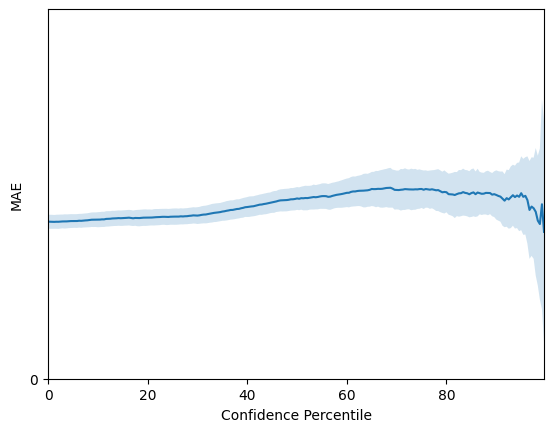

In [8]:
rmse_fragprints, mae_fragprints = evaluate_model(X_fragprints, y)


Beginning training loop...
Starting trial 0
R^2 Model = 0.4805769662937045  vs Y-mean-baseline = -0.00200161043036573
rmse Model = 2.3118483163520636  vs Y-mean-baseline = 3.2109455687588513
mae Model = 1.7577906214958818  vs Y-mean-baseline = 2.693895368011953
Starting trial 1
R^2 Model = 0.46225706920174225  vs Y-mean-baseline = -0.01449921852185021
rmse Model = 2.383559495328383  vs Y-mean-baseline = 3.2738931420629984
mae Model = 1.8468969323088607  vs Y-mean-baseline = 2.7680800633438887
Starting trial 2
R^2 Model = 0.44130054629305127  vs Y-mean-baseline = -1.2830927790918878e-05
rmse Model = 2.4031891583766423  vs Y-mean-baseline = 3.215152809810239
mae Model = 1.852327987751253  vs Y-mean-baseline = 2.700761392064045
Starting trial 3
R^2 Model = 0.4624672550662664  vs Y-mean-baseline = -0.0058584728106625406
rmse Model = 2.269820227421377  vs Y-mean-baseline = 3.1049702150040135
mae Model = 1.7480547076609387  vs Y-mean-baseline = 2.6097427426382898
Starting trial 4
R^2 Model 

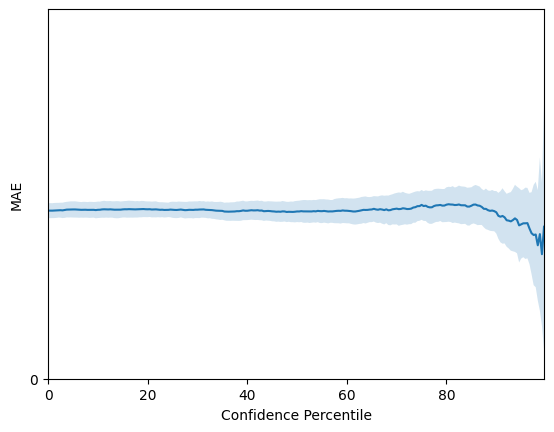

In [9]:
rmse_boc, mae_boc = evaluate_model(X_boc, y)


Beginning training loop...
Starting trial 0
R^2 Model = 0.441940478618995  vs Y-mean-baseline = -0.00200161043036573
rmse Model = 2.3962879007824895  vs Y-mean-baseline = 3.2109455687588513
mae Model = 1.858662445726258  vs Y-mean-baseline = 2.693895368011953
Starting trial 1
R^2 Model = 0.42619785996901627  vs Y-mean-baseline = -0.01449921852185021
rmse Model = 2.4621795710174554  vs Y-mean-baseline = 3.2738931420629984
mae Model = 1.9053578821861767  vs Y-mean-baseline = 2.7680800633438887
Starting trial 2
R^2 Model = 0.3803631280986445  vs Y-mean-baseline = -1.2830927790918878e-05
rmse Model = 2.5308561378415  vs Y-mean-baseline = 3.215152809810239
mae Model = 1.9595938522631182  vs Y-mean-baseline = 2.700761392064045
Starting trial 3
R^2 Model = 0.37168495325951945  vs Y-mean-baseline = -0.0058584728106625406
rmse Model = 2.4540179175861887  vs Y-mean-baseline = 3.1049702150040135
mae Model = 1.9371642083376988  vs Y-mean-baseline = 2.6097427426382898
Starting trial 4
R^2 Model = 

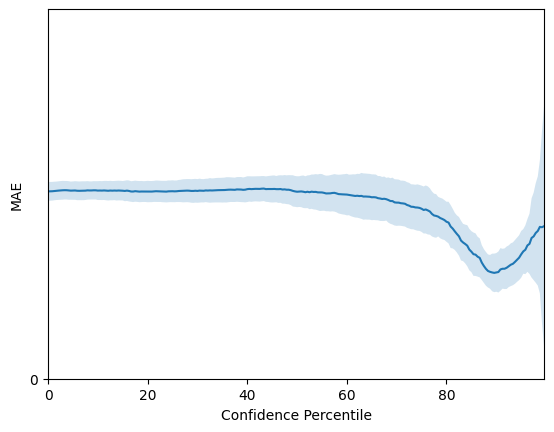

In [10]:
rmse_mordred, mae_mordred = evaluate_model(X_mordred, y, use_mordred=True)